# German Numer

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Loading german numer

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/german_numer(1000,24).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'german'
file_name = data_name

x_tr = x_tr.T
x_tr = x_tr.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)

x_tr = (x_tr + 1) / 2
y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]
dim, num = x_tr.shape
print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 800
of features: 24
german


## K-Means cluster centers

In [3]:
ind_num = 50
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
cov_params = np.array([1., .5, 0.01])

## svi-L-BFGS-B-c method

In [24]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
new_gp = GPC(model_covariance_obj, method='svi')

In [25]:
opts = {'mode': 'full', 'maxiter': 200, 'mydisp': False}
svi_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [26]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

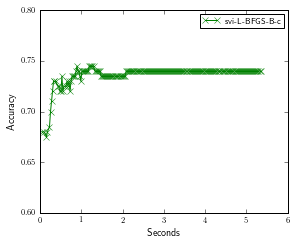

In [27]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [28]:
svi_res.params[-1][:3]

array([  9.58838891e+00,   1.42344778e+01,   1.00000000e-02])

## vi-means-c method

In [29]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
new_gp = GPC(model_covariance_obj, method='vi')

In [30]:
opts = {'maxiter':5, 'mydisp': False}
vi_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=100)

In [31]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)

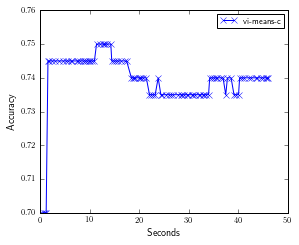

In [32]:
plt.plot(vi_x_lst[1:100], vi_y_lst[1:100], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.7, 0.76])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c

In [18]:
results = []
steps = [1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    new_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 500, 'verbose': False, 'batch_size': 50, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

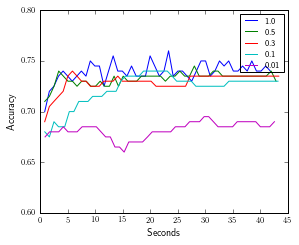

In [19]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=10)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [21]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
new_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 500, 'verbose': True, 'batch_size': 50, 
        'step_rate': 0.3, 'print_freq':50}
batch_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  800 :
	Gradient norm 4.6364957166
Iteration  1600 :
	Gradient norm 5.82355832642
Iteration  2400 :
	Gradient norm 5.09372291018
Iteration  3200 :
	Gradient norm 3.97157687289
Iteration  4000 :
	Gradient norm 4.01398938834
Iteration  4800 :
	Gradient norm 6.42021491235
Iteration  5600 :
	Gradient norm 7.98128873856
Iteration  6400 :
	Gradient norm 4.30107610981
Iteration  7200 :
	Gradient norm 8.18277721624
Iteration  8000 :
	Gradient norm 5.65998924403


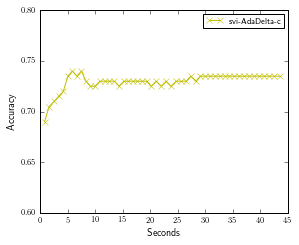

In [22]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=10)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

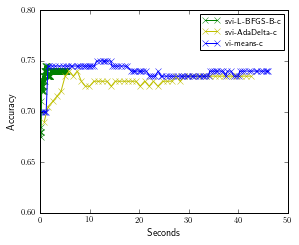

In [33]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:50], svi_ad_y_lst[1:50], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:100], vi_y_lst[1:100], '-bx', label='vi-means-c')
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

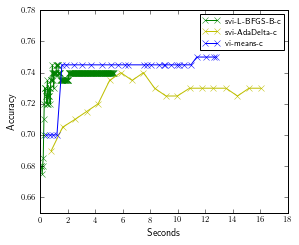

In [34]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:20], svi_ad_y_lst[1:20], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:30], vi_y_lst[1:30], '-bx', label='vi-means-c')
plt.ylim([0.65, 0.78])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [35]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'ad_y.npy', svi_ad_y_lst)